# doing it w fake data

**Purpose:** Explore modeling approaches (Random Forests, PyTorch NN) to predict adjusted beauty score and recommend frames.
**Run notes:** Run `preprocess.py` first to create `data/` artifacts. Save trained models under `models/` and use `recommend.py` for inference.
**Repo readiness:** This notebook is intended to stay as an executable analysis artifact for GitHub — remove API keys and large binary outputs from git.

## NN vs Rand forrest

this version compares both the random forests with the neural net

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

# --- Load CSV ---
df = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# --- Prepare features and target ---
X = df[['FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
        'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance', 'WearsGlasses']]
y = df['AdjustedBeautyScore']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - R2: {rf_r2:.2f}, RMSE: {rf_rmse:.2f}")

# --- Neural Network with PyTorch ---
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Prepare tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Model, loss, optimizer
model = Net(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy().flatten()

nn_r2 = r2_score(y_test, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print(f"Neural Network - R2: {nn_r2:.2f}, RMSE: {nn_rmse:.2f}")

# --- Compare Results ---
if rf_r2 > nn_r2:
    print("Random Forest performed better on your data.")
else:
    print("Neural Network performed better on your data.")


Random Forest - R2: 0.76, RMSE: 0.41
Neural Network - R2: -5.53, RMSE: 2.10
Random Forest performed better on your data.


### Working the data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# --- Load CSV ---
df = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# --- Filter to only rows where WearsGlasses == 1 ---
df = df[df['WearsGlasses'] == 1].reset_index(drop=True)

# --- Prepare features and target (exclude WearsGlasses from X) ---
X = df[['FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
        'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance']]
y = df['AdjustedBeautyScore']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- GridSearchCV for Random Forest ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# --- Evaluate Best Model ---
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Best parameters:", grid_search.best_params_)
print(f"Random Forest - R2: {rf_r2:.2f}, RMSE: {rf_rmse:.2f}")


ModuleNotFoundError: No module named 'seaborn'

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - R2: 0.73, RMSE: 0.43


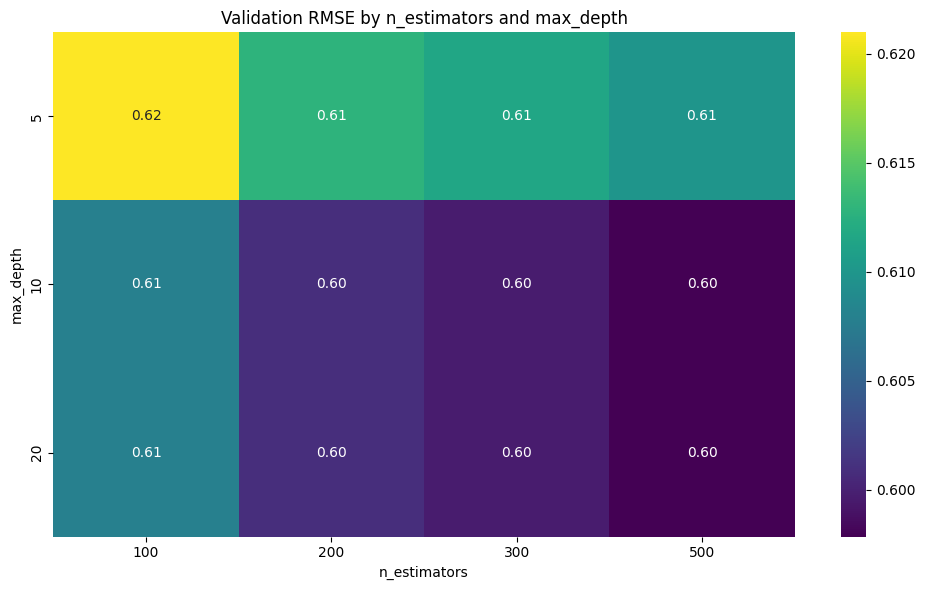

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# --- Load CSV ---
df = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# --- Prepare features and target (exclude WearsGlasses from X) ---
X = df[['FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
        'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance', 'WearsGlasses']]
y = df['AdjustedBeautyScore']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Expanded Grid Search ---
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

# --- Evaluate Best Model ---
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Best parameters:", grid_search.best_params_)
print(f"Random Forest - R2: {rf_r2:.2f}, RMSE: {rf_rmse:.2f}")

# --- Visualize Grid Search Results ---
# Convert results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Example: Visualize RMSE for different n_estimators and max_depth
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

# Plot heatmap (remember: scores are negative RMSEs)
plt.figure(figsize=(10, 6))
sns.heatmap(-pivot_table, annot=True, fmt=".2f", cmap="viridis")  # Negate to show actual RMSE
plt.title("Validation RMSE by n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


## Classifier

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [31]:
### Have to merge the dfs from the 2 csvs ###
df1 = pd.read_csv("Expanded_Face-to-Frame_Matching_Dataset.csv")
df2 = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# Drop duplicate FaceID rows in df2, keeping the first occurrence
df2_unique = df2.drop_duplicates(subset='FaceID')

# Merge the enriched columns into df1
columns_to_merge = ['FaceID', 'FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio', 
                    'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance']
df = df1.merge(df2_unique[columns_to_merge], on='FaceID', how='left')

# Get FrameID of the highest BeautyScore per FaceID
max_beauty_frame = df.loc[df.groupby('FaceID')['BeautyScore'].idxmax(), ['FaceID', 'FrameID']]
max_beauty_frame = max_beauty_frame.rename(columns={'FrameID': 'MaxBeauty_FrameID'})

# Merge back into original dataframe
df = df.merge(max_beauty_frame, on='FaceID', how='left')


In [32]:
df

,FaceID,FrameID,FaceShape,BeautyScore,Shape,AdjustedBeautyScore,FacialSymmetry,GoldenRatioDeviation,EyeSpacingRatio,JawlineWidthRatio,BrowToEyeDistance,LipToNoseDistance,MaxBeauty_FrameID
0,F001,FRM086,Oval,4.57,Cat-Eye,4.97,0.94,0.21,0.55,0.84,1.09,1.41,FRM086
1,F002,FRM086,Long,4.81,Cat-Eye,4.81,0.65,0.02,0.50,1.04,0.85,1.78,FRM086
2,F007,FRM086,Oval,4.36,Cat-Eye,4.76,0.70,0.05,0.31,0.85,1.13,1.39,FRM086
3,F030,FRM086,Oval,4.83,Cat-Eye,5.23,0.73,0.01,0.56,0.89,1.03,1.05,FRM086
4,F032,FRM086,Round,3.23,Cat-Eye,3.23,0.71,0.27,0.37,1.04,0.96,1.02,FRM086
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,F021,FRM039,Round,3.06,Round,3.06,0.73,0.09,0.59,0.89,1.24,1.76,FRM018
496,F016,FRM039,Long,4.07,Round,4.27,0.95,0.05,0.51,1.08,0.93,1.53,FRM097
497,F003,FRM087,Long,4.75,Oversized,5.15,0.88,0.27,0.36,1.02,1.12,1.48,FRM063
498,F015,FRM087,Oval,3.90,Oversized,3.90,0.62,0.17,0.45,1.19,0.90,1.69,FRM023


In [ ]:
# --- Encode categorical target if needed ---
if df['FrameID'].dtype == object:
    le = LabelEncoder()
    df['FrameID'] = le.fit_transform(df['FrameID'])
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Label mapping:", label_mapping)

# --- Prepare features and target (drop WearsGlasses if present) ---
X = df[['FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
        'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance']]
y = df['MaxBeauty_FrameID']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define parameter grid for classification ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# --- Fit classifier ---
grid_search.fit(X_train, y_train)

# --- Evaluate best model ---
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Best parameters:", grid_search.best_params_)
print(f"Accuracy on test set: {acc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Confusion matrix heatmap ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted FrameID")
plt.ylabel("True FrameID")
plt.tight_layout()
plt.show()

# --- Feature Importance ---
importances = best_clf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(feature_names[sorted_indices], importances[sorted_indices])
plt.title("Feature Importances for FrameID Classification")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Encode FrameID if needed ---
if df['FrameID'].dtype == object:
    le = LabelEncoder()
    df['FrameID'] = le.fit_transform(df['FrameID'])
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("FrameID label mapping:", label_mapping)

# --- Encode MaxBeauty_FrameID as target ---
le_target = LabelEncoder()
df['MaxBeauty_FrameID'] = le_target.fit_transform(df['MaxBeauty_FrameID'])
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print("MaxBeauty_FrameID label mapping:", target_mapping)

# --- Check class distribution ---
print("🔍 Class distribution in MaxBeauty_FrameID:\n", df['MaxBeauty_FrameID'].value_counts())

# --- Prepare features and target (drop WearsGlasses if present) ---
X = df[['FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
        'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance']]
y = df['MaxBeauty_FrameID']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    # stratify=y  # Optional: uncomment if you want stratified split
)

# --- Define parameter grid for classification ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# --- Fit classifier ---
grid_search.fit(X_train, y_train)

# --- Evaluate best model ---
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Best parameters:", grid_search.best_params_)
print(f"Accuracy on test set: {acc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# --- Confusion matrix heatmap ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted FrameID")
plt.ylabel("True FrameID")
plt.tight_layout()
plt.show()

# --- Feature Importance ---
importances = best_clf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(feature_names[sorted_indices], importances[sorted_indices])
plt.title("Feature Importances for FrameID Classification")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
### Look up frame info ###

# Predict a frame for a new sample (just as an example):
sample = X_test.iloc[0:1]
predicted_id = clf.predict(sample)[0]
frame_label = target_encoder.inverse_transform([predicted_id])[0]

# Lookup the full frame details
frame_info = df[df['FrameID'] == predicted_id].iloc[0]
print("Recommended Frame Info:")
print("FrameID:", frame_label)
print("Brand:", frame_info['Brand'])
print("Shape:", frame_info['Shape'])
print("Color:", frame_info['Color'])


## Regression

### prep data

In [51]:
### Have to merge the dfs from the 2 csvs ###
df1 = pd.read_csv("Expanded_Face-to-Frame_Matching_Dataset.csv")
df2 = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# Drop duplicate FaceID rows in df2, keeping the first occurrence
df2_unique = df2.drop_duplicates(subset='FaceID')

# Merge the enriched columns into df1
columns_to_merge = ['FaceID', 'FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
                    'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance', 'Brand', 'Material', 'RimStyle', 'BridgeType', 'Color',
                    'Width_mm', 'LensHeight_mm', 'LensWidth_mm', 'NoseBridgeWidth_mm', 'TempleLength_mm']
df = df1.merge(df2_unique[columns_to_merge], on='FaceID', how='left')

# Get FrameID of the highest BeautyScore per FaceID
max_beauty_frame = df.loc[df.groupby('FaceID')['BeautyScore'].idxmax(), ['FaceID', 'FrameID']]
max_beauty_frame = max_beauty_frame.rename(columns={'FrameID': 'MaxBeauty_FrameID'})

# Merge back into original dataframe
df = df.merge(max_beauty_frame, on='FaceID', how='left')

In [52]:
# --- Separate face and frame features ---
face_features = [
    'FaceID', 'FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
    'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance'
]

frame_features = [
    'FrameID', 'Brand', 'Shape', 'Material', 'RimStyle', 'BridgeType', 'Color',
    'Width_mm', 'LensHeight_mm', 'LensWidth_mm', 'NoseBridgeWidth_mm', 'TempleLength_mm'
]

target_col = 'AdjustedBeautyScore'

# Keep only relevant columns
df_model = df[face_features + frame_features + [target_col]].copy()


In [53]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical frame features
categorical_cols = ['Brand', 'Shape', 'Material', 'RimStyle', 'BridgeType', 'Color']
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


In [54]:
X = df_encoded.drop(columns=['FaceID', 'FrameID', target_col])
y = df_encoded[target_col]


### train

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GroupShuffleSplit

# Prepare data (with FaceID still present)
X = df_encoded.drop(columns=['FrameID', target_col])  # Keep 'FaceID' temporarily
y = df_encoded[target_col]
groups = df_encoded['FaceID']

# Use GroupShuffleSplit to avoid face leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx].drop(columns=['FaceID']), X.iloc[test_idx].drop(columns=['FaceID'])
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


# Train model
reg = RandomForestRegressor(n_estimators=200, random_state=42)
reg.fit(X_train, y_train)

# Evaluate
y_pred = reg.predict(X_test)
print(f"Test RMSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.2f}")


Test RMSE: 1.46
Test R^2: -0.84


In [72]:
baseline = y_test.copy()
frame_means = df.groupby('FrameID')['AdjustedBeautyScore'].mean().to_dict()
baseline_pred = df_encoded.iloc[test_idx]['FrameID'].map(frame_means)
print("Baseline RMSE:", mean_squared_error(y_test, baseline_pred))


Baseline RMSE: 0.8007227256637167


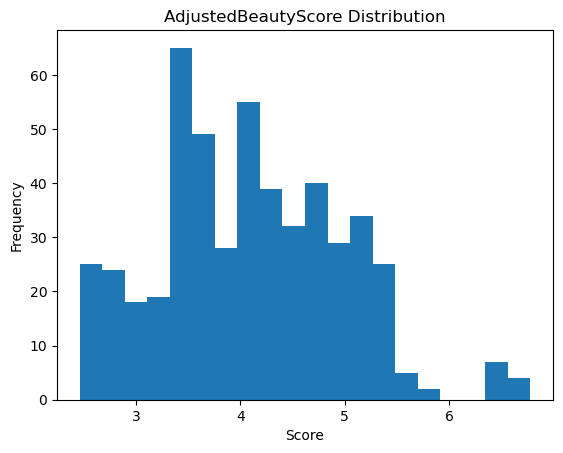

In [66]:
import matplotlib.pyplot as plt
plt.hist(y, bins=20)
plt.title("AdjustedBeautyScore Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


### recommend

In [64]:
def recommend_frames_for_face(new_face, reg, frame_catalog, X_columns, top_k=5):
    """
    Recommend top-k eyeglass frames for a new face using a trained regressor.

    Parameters:
    - new_face: dict of facial features
    - reg: trained regression model
    - frame_catalog: DataFrame of unique frame features
    - X_columns: list of model feature columns (to match one-hot encoding)
    - top_k: number of frames to recommend

    Returns:
    - DataFrame of top-k recommended frames with predicted scores
    """
    # Duplicate the face row for each frame
    new_face_df = pd.DataFrame([new_face] * len(frame_catalog)).reset_index(drop=True)
    frame_df = frame_catalog.reset_index(drop=True)
    combined_df = pd.concat([new_face_df, frame_df], axis=1)

    # One-hot encode frame features
    categorical_cols = ['Brand', 'Shape', 'Material', 'RimStyle', 'BridgeType', 'Color']
    combined_encoded = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

    # Align with training feature columns
    for col in X_columns:
        if col not in combined_encoded:
            combined_encoded[col] = 0
    combined_encoded = combined_encoded[X_columns]  # enforce column order

    # Predict beauty scores
    combined_df['PredictedBeautyScore'] = reg.predict(combined_encoded)

    # Return top-k recommendations
    top_recs = combined_df.sort_values(by='PredictedBeautyScore', ascending=False).head(top_k)
    return top_recs[['FrameID', 'Brand', 'Shape', 'Color', 'PredictedBeautyScore']]


In [65]:
# Example: define a new user's face
new_face = {
    'FacialSymmetry': 0.86,
    'GoldenRatioDeviation': 0.15,
    'EyeSpacingRatio': 0.45,
    'JawlineWidthRatio': 1.05,
    'BrowToEyeDistance': 1.2,
    'LipToNoseDistance': 1.4
}

# Build frame catalog (once)
frame_catalog = df_model[frame_features].drop_duplicates(subset='FrameID')

# Make recommendations
recommendations = recommend_frames_for_face(
    new_face=new_face,
    reg=reg,
    frame_catalog=frame_catalog,
    X_columns=X.columns,
    top_k=5
)

# Show results
print("Top Frame Recommendations:")
display(recommendations)



Top Frame Recommendations:


,FrameID,Brand,Shape,Color,PredictedBeautyScore
23,FRM023,Oakley,Rectangle,Blue,5.69195
50,FRM096,Oakley,Wayfarer,Blue,5.69130
17,FRM027,Ray-Ban,Wayfarer,Silver,5.67790
24,FRM019,Oakley,Browline,Blue,5.67405
59,FRM041,Ray-Ban,Geometric,Silver,5.66255


## NN?

In [73]:
### Have to merge the dfs from the 2 csvs ###
df1 = pd.read_csv("Expanded_Face-to-Frame_Matching_Dataset.csv")
df2 = pd.read_csv("Recommended_Eyeglass_Frames_By_Adjusted_Beauty_Score.csv")

# Drop duplicate FaceID rows in df2, keeping the first occurrence
df2_unique = df2.drop_duplicates(subset='FaceID')

# Merge the enriched columns into df1
columns_to_merge = ['FaceID', 'FacialSymmetry', 'GoldenRatioDeviation', 'EyeSpacingRatio',
                    'JawlineWidthRatio', 'BrowToEyeDistance', 'LipToNoseDistance', 'Brand', 'Material', 'RimStyle', 'BridgeType', 'Color',
                    'Width_mm', 'LensHeight_mm', 'LensWidth_mm', 'NoseBridgeWidth_mm', 'TempleLength_mm']
df = df1.merge(df2_unique[columns_to_merge], on='FaceID', how='left')

# Get FrameID of the highest BeautyScore per FaceID
max_beauty_frame = df.loc[df.groupby('FaceID')['BeautyScore'].idxmax(), ['FaceID', 'FrameID']]
max_beauty_frame = max_beauty_frame.rename(columns={'FrameID': 'MaxBeauty_FrameID'})

# Merge back into original dataframe
df = df.merge(max_beauty_frame, on='FaceID', how='left')

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

# Prepare features and target
X = df_encoded.drop(columns=['FrameID', target_col])  # Keep FaceID for now
y = df_encoded[target_col]
groups = df_encoded['FaceID']

# Group-aware split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train = X.iloc[train_idx].drop(columns=['FaceID'])
X_test = X.iloc[test_idx].drop(columns=['FaceID'])
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [75]:
class FrameRecommenderNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
input_dim = X_train_tensor.shape[1]
model = FrameRecommenderNN(input_dim)


In [76]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")


Epoch 1/50 - Train Loss: 14.3030
Epoch 2/50 - Train Loss: 6.7970
Epoch 3/50 - Train Loss: 1.4656
Epoch 4/50 - Train Loss: 0.9444
Epoch 5/50 - Train Loss: 0.6524
Epoch 6/50 - Train Loss: 0.5383
Epoch 7/50 - Train Loss: 0.4884
Epoch 8/50 - Train Loss: 0.4468
Epoch 9/50 - Train Loss: 0.3920
Epoch 10/50 - Train Loss: 0.3855
Epoch 11/50 - Train Loss: 0.3546
Epoch 12/50 - Train Loss: 0.3324
Epoch 13/50 - Train Loss: 0.3262
Epoch 14/50 - Train Loss: 0.2840
Epoch 15/50 - Train Loss: 0.3112
Epoch 16/50 - Train Loss: 0.3034
Epoch 17/50 - Train Loss: 0.2966
Epoch 18/50 - Train Loss: 0.2532
Epoch 19/50 - Train Loss: 0.2289
Epoch 20/50 - Train Loss: 0.2505
Epoch 21/50 - Train Loss: 0.2797
Epoch 22/50 - Train Loss: 0.2525
Epoch 23/50 - Train Loss: 0.2743
Epoch 24/50 - Train Loss: 0.2685
Epoch 25/50 - Train Loss: 0.2535
Epoch 26/50 - Train Loss: 0.2693
Epoch 27/50 - Train Loss: 0.2273
Epoch 28/50 - Train Loss: 0.2677
Epoch 29/50 - Train Loss: 0.2656
Epoch 30/50 - Train Loss: 0.2570
Epoch 31/50 - Trai

In [80]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()
    y_true = y_test_tensor.squeeze().numpy()

rmse = mean_squared_error(y_true, preds)
print(f"PyTorch Neural Net Test RMSE: {rmse:.2f}")


PyTorch Neural Net Test RMSE: 1.62
